## Emotion detection architecture

### API handling

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od
import os

dataset_url = 'https://www.kaggle.com/datasets/msambare/fer2013'
od.download(dataset_url)

# 3. Verify the download
data_dir = './fer2013'
print("\nContents of the folder:")
print(os.listdir(data_dir))

# Check inside 'train' to see the emotions
print("\nEmotion classes found:")
print(os.listdir(os.path.join(data_dir, 'train')))

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: xaxuser12
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013


100%|██████████| 60.3M/60.3M [00:00<00:00, 1.30GB/s]


Contents of the folder:
['train', 'test']

Emotion classes found:
['surprise', 'sad', 'disgust', 'angry', 'fear', 'neutral', 'happy']


### The model

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import opendatasets as od
import os
import shutil

# --- 1. DEVICE HANDLING ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"⚙️ Computation Device: {device}")

# --- 2. DATA DOWNLOAD & CLEANUP ---
# Download FER-2013
dataset_url = 'https://www.kaggle.com/datasets/msambare/fer2013'
if not os.path.exists('./fer2013'):
    print("⬇️ Downloading Dataset (Enter Kaggle credentials if asked)...")
    od.download(dataset_url)
else:
    print("✅ Dataset already exists.")

# Define the path
base_path = './fer2013'
target_classes = ['happy', 'neutral', 'sad']

# Function to remove unwanted classes
def filter_emotions(folder_path, keep_classes):
    if not os.path.exists(folder_path): return
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if class_name not in keep_classes and os.path.isdir(class_path):
            shutil.rmtree(class_path) # Delete unwanted folder
            print(f"   Deleted class: {class_name}")

print("\n🧹 Cleaning dataset (keeping only Happy, Sad, Neutral)...")
filter_emotions(os.path.join(base_path, 'train'), target_classes)
filter_emotions(os.path.join(base_path, 'test'), target_classes)

# --- 3. DATA LOADERS ---
# The logic: 48x48 Grayscale -> Tensor
data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# Create datasets
train_dataset = datasets.ImageFolder(os.path.join(base_path, 'train'), transform=data_transforms)
val_dataset = datasets.ImageFolder(os.path.join(base_path, 'test'), transform=data_transforms)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print(f"\n✅ Data Ready!")
print(f"Classes: {train_dataset.classes}")
print(f"Train Images: {len(train_dataset)}")
print(f"Val Images: {len(val_dataset)}")

⚙️ Computation Device: cuda
✅ Dataset already exists.

🧹 Cleaning dataset (keeping only Happy, Sad, Neutral)...
   Deleted class: surprise
   Deleted class: disgust
   Deleted class: angry
   Deleted class: fear
   Deleted class: surprise
   Deleted class: disgust
   Deleted class: angry
   Deleted class: fear

✅ Data Ready!
Classes: ['happy', 'neutral', 'sad']
Train Images: 17010
Val Images: 4254


In [4]:
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()

        # Block 1: Input (Batch, 1, 48, 48)
        # Suggestion: Use 32 filters, kernel 3, padding 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3,padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2) # Output becomes (32, 24, 24)

        # Block 2: Input (Batch,32, 24, 24)
        # Suggestion: Double filters to 64, padding 1
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2) # Output becomes (64, 12, 12)

        # Block 3: Input (Batch, 64, 12, 12)
        # Suggestion: Double filters to 128, padding 1
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2) # Output becomes (128, 6, 6)

        # Classifier Head
        # Math Check: 128 channels * 6 height * 6 width
        self.fc1 = nn.Linear(128*6*6, 256)
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256,3)

    def forward(self, x):
        # Write the flow of data
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.fc2(self.drop(F.relu(self.fc1(x))))
        return x

# Move to GPU
model = EmotionCNN().to(device)
print(model)

EmotionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=256, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)


In [5]:
# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Simple Training Loop (Condensed Version)
def train_fast(model, epochs=15):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Epoch {epoch+1} | Loss: {running_loss/len(train_loader):.4f} | Acc: {100 * correct / total:.2f}%")

# Start Training
print("🚀 Starting Training on Emotions...")
train_fast(model)

🚀 Starting Training on Emotions...
Epoch 1 | Loss: 1.0349 | Acc: 49.30%
Epoch 2 | Loss: 0.8225 | Acc: 60.44%
Epoch 3 | Loss: 0.7665 | Acc: 63.77%
Epoch 4 | Loss: 0.7201 | Acc: 66.27%
Epoch 5 | Loss: 0.7017 | Acc: 67.71%
Epoch 6 | Loss: 0.6716 | Acc: 69.12%
Epoch 7 | Loss: 0.6444 | Acc: 70.32%
Epoch 8 | Loss: 0.6267 | Acc: 71.93%
Epoch 9 | Loss: 0.5997 | Acc: 72.63%
Epoch 10 | Loss: 0.5708 | Acc: 73.61%
Epoch 11 | Loss: 0.5445 | Acc: 75.13%
Epoch 12 | Loss: 0.5176 | Acc: 76.59%
Epoch 13 | Loss: 0.4952 | Acc: 77.21%
Epoch 14 | Loss: 0.4723 | Acc: 78.54%
Epoch 15 | Loss: 0.4433 | Acc: 79.47%


## Face detection

✅ Found 9 faces!


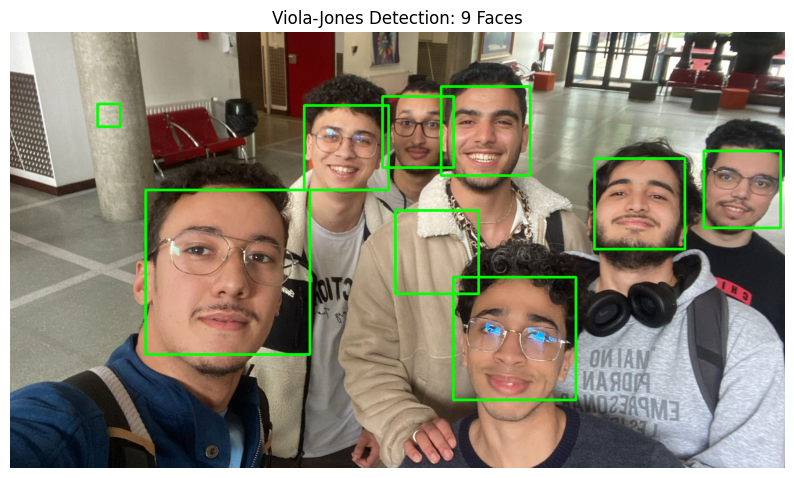

In [7]:
import cv2
import matplotlib.pyplot as plt

def detect_faces_violajones(image_path):

    cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
    face_cascade = cv2.CascadeClassifier(cascade_path)

    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Error: Could not find image '{image_path}'")
        return

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    print(f"✅ Found {len(faces)} faces!")

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for (x, y, w, h) in faces:

        cv2.rectangle(img_rgb, (x, y), (x+w, y+h), (0, 255, 0), 5)

    # 6. Show Result
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Viola-Jones Detection: {len(faces)} Faces")
    plt.show()

#detect_faces_violajones('Badr_Yahya.jpg')
detect_faces_violajones('hh.jpeg')

## Face Emotion

In [8]:
from PIL import Image

class_names = ['happy', 'neutral', 'sad']

inference_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor()
])

def detect_and_predict_emotions(image_path, model):

    cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
    face_cascade = cv2.CascadeClassifier(cascade_path)

    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Error: Could not find image '{image_path}'")
        return

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    print(f"✅ Found {len(faces)} faces. Analyzing emotions...")

    # Convert to RGB for display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for (x, y, w, h) in faces:

        face_crop = img_rgb[y:y+h, x:x+w]

        pil_img = Image.fromarray(face_crop)
        img_tensor = inference_transform(pil_img).unsqueeze(0).to(device)

        # PREDICT
        model.eval()
        with torch.no_grad():
            outputs = model(img_tensor)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            confidence, predicted_idx = torch.max(probs, 1)

        emotion_label = class_names[predicted_idx.item()]
        conf_score = confidence.item() * 100

        # Box and Text
        # Color Coding: Green (Happy), Red (Sad), Yellow (Neutral)
        if emotion_label == 'happy': color = (0, 255, 0)
        elif emotion_label == 'sad': color = (255, 0, 0)
        else: color = (255, 255, 0)

        cv2.rectangle(img_rgb, (x, y), (x+w, y+h), color, 4)

        # Add label background for readability
        cv2.rectangle(img_rgb, (x, y-30), (x+w, y), color, -1)
        cv2.putText(img_rgb, f"{emotion_label} {conf_score:.0f}%", (x+5, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 2)

    # DISPLAY FINAL RESULT ---
    plt.figure(figsize=(12, 12))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Emotion Detection Results")
    plt.show()


✅ Found 9 faces. Analyzing emotions...


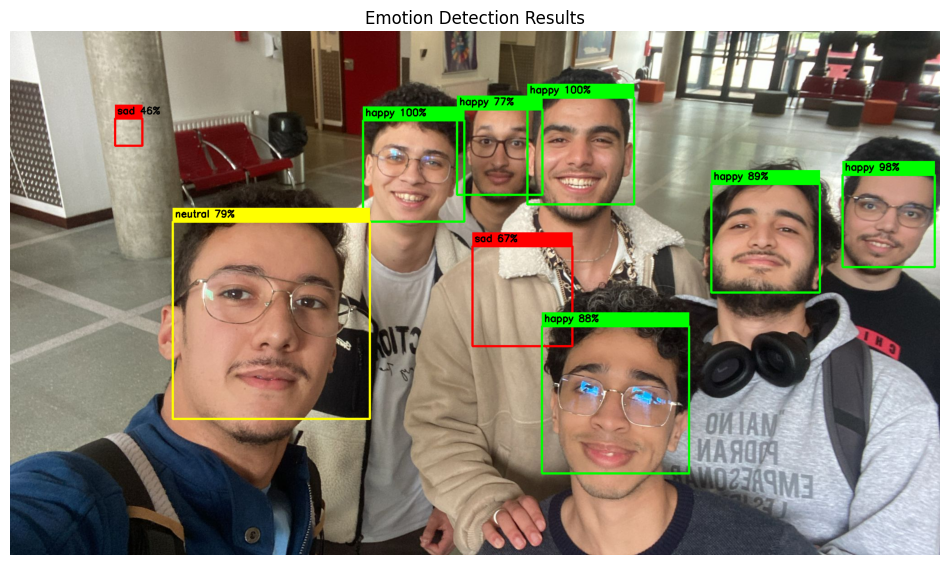

In [9]:
detect_and_predict_emotions('hh.jpeg', model)

## Saving the model

In [10]:
from google.colab import files

# 1. Save the trained model parameters to a file
print("💾 Saving model...")
torch.save(model.state_dict(), 'emotion_model.pth')

💾 Saving model...
